In [1]:
import numpy as np
import os, cv2
from sklearn.utils import shuffle
from imutils import build_montages
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, Input, LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Activation, Dense, Flatten, Reshape

# 1 - Implement DCGAN

In [2]:
class DCGAN:
    
    """Build the generator module
    Arguments:
        dim:        the target spatial dimensions (width & height) of the generator after reshaping
        depth:      the target depth of the volumn after reshaping
        channels:   the number of channels in the output volume from the generator (1: grayscale, 3: RGB)
        inputDim:   dimensionality of the randomly generated input vector to the generator
        outputDim:  dimensionality of the output fully-connected layer from the randomly generated input vector
    """
    @staticmethod
    def build_generator(dim, depth, channels=1, inputDim=100, outputDim=512):
        #initialize the model
        model = Sequential()
        inputShape = (dim, dim, depth)
        chanDim = -1
        #1st FC layer: fully-connected -> relu -> normalization
        model.add(Dense(input_dim=inputDim, units=outputDim))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        #2nd FC layer: fully-connected -> relu -> normalization
        model.add(Dense(units=dim*dim*depth))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        #1st conv layer: reshape -> Conv2d -> relu -> normalization
        model.add(Reshape(inputShape))
        model.add(Conv2DTranspose(32,(5,5), strides=(2,2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        #output layer: Conv2d -> tanh
        model.add(Conv2DTranspose(channels,(5,5),strides=(2,2),padding="same"))
        model.add(Activation("tanh"))
        return model
    

    @staticmethod
    def build_discriminator(width, height, depth, alpha=0.2):
        #initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
        #1st conv layer: Conv2d -> leakyrelu
        model.add(Conv2D(32,(5,5),padding="same",strides=(2,2),input_shape=inputShape))
        model.add(LeakyReLU(alpha=alpha))
        #2nd conv layer: Conv2d -> leakyrelu
        model.add(Conv2D(64,(5,5),padding="same",strides=(2,2)))
        model.add(LeakyReLU(alpha=alpha))
        #1st FC layer: fully-connected -> leakyrelu
        model.add(Flatten())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=alpha))
        #output model
        model.add(Dense(1))
        model.add(Activation("sigmoid"))
        return model

# 2 - Training on MNIST

## 2.1 Configuration

In [3]:
OUTPUT = './output'
NUM_EPOCHS = 50 
BATCH_SIZE = 128 
PROGRESS_SAVE = False

## 2.2 Load MNIST

In [4]:
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
trainImages = np.concatenate([trainX, testX])
trainImages = np.expand_dims(trainImages, axis=-1)
trainImages = (trainImages.astype("float") - 127.5) / 127.5

[INFO] loading MNIST dataset...


## 2.3 - Initialize DCGAN

In [5]:
print("[INFO] building genertor...")
gen = DCGAN.build_generator(7, 64, channels=1)

print("[INFO] building discriminator...")
disc = DCGAN.build_discriminator(28, 28, 1)
discOpt = Adam(learning_rate=0.0002, beta_1=0.5, decay=0.0002/NUM_EPOCHS)
disc.compile(loss="binary_crossentropy", optimizer=discOpt)

[INFO] building genertor...
[INFO] building discriminator...


In [6]:
print("[INFOR] building GAN...")
disc.trainable = False
ganInput = Input(shape=(100,))
ganOutput = disc(gen(ganInput))
gan = Model(ganInput, ganOutput)

#Compile the GAN
ganOpt = Adam(learning_rate=0.0002, beta_1=0.5, decay=0.0002/NUM_EPOCHS)
gan.compile(loss="binary_crossentropy", optimizer=ganOpt)

[INFOR] building GAN...


## 2.4 - Training

In [7]:
print("[INFO] starting training...")
benchmarkNoise = np.random.uniform(-1, 1, size=(256, 100))

# loop over the epochs
for epoch in range(NUM_EPOCHS):
    print("[INFO] starting epoch {} of {}".format(epoch+1, NUM_EPOCHS))
    batchesPerEpoch = int(trainImages.shape[0]/BATCH_SIZE)
    
    #loop over the batches
    for i in range(0, batchesPerEpoch):
        p = None        #initialize an empty output path

        # select the next batch of images, then randomly generate noise for the generator to predict on
        imageBatch = trainImages[i * BATCH_SIZE:(i+1) * BATCH_SIZE]
        noise = np.random.uniform(-1,1,size=(BATCH_SIZE,100))

        # generate image using noise + generator model
        genImages = gen.predict(noise, verbose=0)

        # concatenate the *actual* images and the *generated* images, 
        # construct class labels for the discriminator, and shuffle
        X = np.concatenate((imageBatch, genImages))
        y = np.array(([1]*BATCH_SIZE) + ([0]*BATCH_SIZE))
        (X, y) = shuffle(X,y)

        # train the discriminator
        discLoss = disc.train_on_batch(X, y)

        # train the generator by generate randome noise & freeze discriminator
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        ganLoss = gan.train_on_batch(noise, np.array([1]*BATCH_SIZE))


        # if end of an epoch, create path for output image
        if i == (batchesPerEpoch - 1):
            p = [OUTPUT, "epoch_{}_output.png".format(str(epoch+1).zfill(4))]
        
        # else create path for visualize training generated images
        elif PROGRESS_SAVE:
            if epoch < 10 and i%25==0:
                p = [OUTPUT, "epoch_{}_step_{}.png".format(str(epoch+1).zfill(4), str(i).zfill(5))]
            elif epoch >= 10 and i%50==0:
                p = [OUTPUT, "epoch_{}_step_{}.png".format(str(epoch+1).zfill(4), str(i).zfill(5))]
        
        if p is not None:
            print(f"[INFO] Step {epoch+1}_{i}: disc_loss={discLoss:.6f}, gan_loss:{ganLoss:.6f}")
            images = gen.predict(benchmarkNoise)
            images = ((images*127.5)+127.5).astype("uint8")
            images = np.repeat(images,3,axis=-1)
            vis = build_montages(images, (28,28), (16,16))[0]
            p = os.path.sep.join(p)
            cv2.imwrite(p, vis)

[INFO] starting training...
[INFO] starting epoch 1 of 50
[INFO] Step 1_545: disc_loss=0.266900, gan_loss:2.066391
8/8 [==============================] - 0s 1ms/step
[INFO] starting epoch 2 of 50
[INFO] Step 2_545: disc_loss=0.387719, gan_loss:1.326850
8/8 [==============================] - 0s 2ms/step
[INFO] starting epoch 3 of 50
[INFO] Step 3_545: disc_loss=0.413367, gan_loss:1.234157
8/8 [==============================] - 0s 3ms/step
[INFO] starting epoch 4 of 50
[INFO] Step 4_545: disc_loss=0.489871, gan_loss:1.238356
8/8 [==============================] - 0s 2ms/step
[INFO] starting epoch 5 of 50
[INFO] Step 5_545: disc_loss=0.510316, gan_loss:1.231153
8/8 [==============================] - 0s 2ms/step
[INFO] starting epoch 6 of 50
[INFO] Step 6_545: disc_loss=0.491003, gan_loss:1.253783
8/8 [==============================] - 0s 2ms/step
[INFO] starting epoch 7 of 50
[INFO] Step 7_545: disc_loss=0.486286, gan_loss:1.204555
8/8 [==============================] - 0s 2ms/step
[INFO]

Image from the 1st epoch:

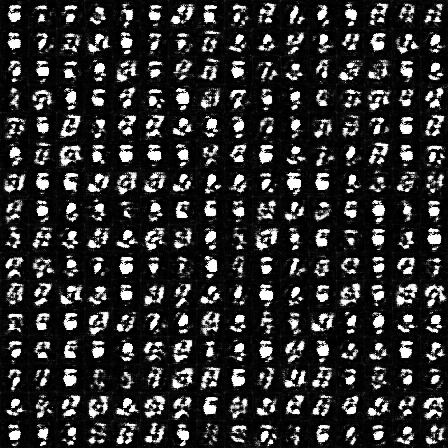

Image from the 50th epoch:

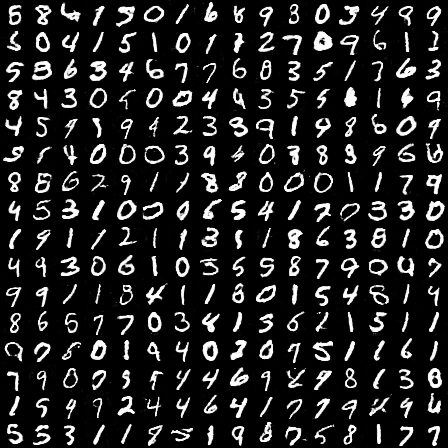